In [105]:
# import require modules
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
# define global variables
absolute_path_csv ='C:\\Users\\rohit\\Downloads\\nba_logreg.csv'
#'D:\\Deep Learning Project\\breast_cancer.csv'
label_encoding_list = [] #should be list
field_not_required = [] # should be list
test_split_ratio = 0.30
output_column_name = 'TARGET_5Yrs'
hidden_layer = 1
hidden_units = [100]
num_iteration = 3000

In [51]:
# data preprocessing function
def data_preprocessing(absolute_path_csv, label_encoding_list ,field_not_required ):
    # asserting function argument data type
    assert isinstance(label_encoding_list, list), "label_encoding_list argument must be a list"
    assert isinstance(field_not_required, list), "field_not_required argument must be a list"
    #import data
    processed_data = pd.read_csv(absolute_path_csv)
    # Label encoding: we will use sklearn preprocessing module for label encoding. In label encoding
    # each class of categorical variable is assigned a unique integer to be used in ML
    #you can use one-Hot-encoding, pandas.map() to achieve similar result. Time complexity needs to be taken care while
    #choosing the approach. Here we have used label encoding without considering any factor
    #There are many other data preprocessing steps we can take like treating missing values, scaling of data etc.
    if len(label_encoding_list) != 0:
        label_encoder = preprocessing.LabelEncoder() # label encoder object is created
        for i in label_encoding_list:
            processed_data[i] = label_encoder.fit_transform(processed_data[i])

    # Removein un-necesary coloumn
    if len(field_not_required) !=0:
        
        for i in field_not_required:
            processed_data = processed_data.drop(i, axis=1)
    return processed_data

In [52]:
# Data split into training and test
def training_test_set(output_column_name, test_split_ratio):
    # asserting parameters expected value
    assert 0 < test_split_ratio < 1, "Test_split_ratio should be between 0 and 1"
    base_processed_data = data_preprocessing(absolute_path_csv, label_encoding_list ,field_not_required)
    #split data into X and Y
    train, test  = train_test_split(base_processed_data, test_size = test_split_ratio )
    train_x = train.drop(output_column_name,axis=1)
    train_y = train[output_column_name]

    test_x = test.drop(output_column_name,axis=1)
    test_y = test[output_column_name]
    
    return np.array(train_x).T,np.array(train_y).reshape(1,-1),np.array(test_x).T,np.array(test_y).reshape(1,-1)

    

In [53]:
 train_x,train_y,test_x,test_y = training_test_set(output_column_name, test_split_ratio)

In [54]:
train_x.shape

(19, 938)

In [91]:
#Neural architecture including weight and bias initialization
def neural_architecture(hidden_layer, hidden_units):
    #train_x,train_y,test_x,test_y = training_test_set(output_column_name, test_split_ratio)
    #asserting variables datatype and structure
    assert isinstance(hidden_layer,int), "hidden_layer value should be of int data type"
    assert isinstance(hidden_units,list), "hidden_units should be of list data structure"
    assert len(hidden_units) == hidden_layer, "length of hidden_unit list should be equal to hidden_layer value"
    n_x = train_x.shape[0] # input layer size
    n_y = train_y.shape[0] # output layer size
    # initialize weights and bias for the hidden and output layer
    weights_hidden_layer = {}
    if hidden_layer != 0:
        for i in range(hidden_layer):
            if i == 0:
                weights_hidden_layer['W'+str(i+1)] = np.random.randn(hidden_units[i],n_x)*0.01
                weights_hidden_layer['b'+str(i+1)] = np.zeros((hidden_units[i],1))
            else:
                weights_hidden_layer['W'+str(i+1)] = np.random.randn(hidden_units[i],hidden_units[i-1])*0.01
                weights_hidden_layer['b'+ str(i+1)] = np.zeros((hidden_units[i],1))
        weights_hidden_layer['W'+str(len(hidden_units)+1)] = np.random.randn(n_y,hidden_units[len(hidden_units)-1])*0.01
        weights_hidden_layer['b' + str(len(hidden_units)+1)] =np.zeros((1,1))
    else:
        weights_hidden_layer['W'+str(1)] = np.random.randn(n_y,n_x)*0.01
        weights_hidden_layer['b'+str(1)] = np.zeros((1,1))

    return weights_hidden_layer
    

In [19]:
weights_hidden_layer = neural_architecture(hidden_layer, hidden_units)

In [22]:
weights_hidden_layer['W1'].shape

(100, 30)

In [113]:
# forward propogation
def forward_propogation(train_x , weights = neural_architecture(hidden_layer, hidden_units)):
    #weights_hidden_layer = neural_architecture(hidden_layer, hidden_units)
    weights_hidden_layer = weights
    #train_x,train_y,test_x,test_y = training_test_set(output_column_name, test_split_ratio)
    forward_computation = {}
    forward_computation['A0'] = train_x
    if hidden_layer != 0:
        for i in range(hidden_layer):
            forward_computation['Z'+str(i+1)] = np.dot(weights_hidden_layer['W'+str(i+1)],forward_computation['A'+str(i)])+weights_hidden_layer['b'+str(i+1)]
            forward_computation['A'+str(i+1)] = np.tanh(forward_computation['Z'+str(i+1)])
        forward_computation['Z'+str(len(hidden_units)+1)]= np.dot(weights_hidden_layer['W'+str(len(hidden_units)+1)],forward_computation['A'+str(len(hidden_units))])+weights_hidden_layer['b'+str(len(hidden_units)+1)]
        forward_computation['A'+str(len(hidden_units)+1)] = 1/(1+ np.exp(-1*forward_computation['Z'+str(len(hidden_units)+1)]))                                                         
    else:
        forward_computation['Z1'] = np.dot(weights_hidden_layer['W1'],forward_computation['A0'])+weights_hidden_layer['b1']
        forward_computation['A1'] = 1/(1+np.exp(-1*forward_computation['Z1']))
    
    return forward_computation

In [24]:
#Cost computation
def cost_computation(f_computation = forward_propogation(train_x)):
    forward_computation = f_computation
    #train_x,train_y,test_x,test_y = training_test_set(output_column_name, test_split_ratio)
    m = train_x.shape[1]
    log_probs = np.multiply(np.log(forward_computation['A'+str(hidden_layer +1)]),train_y)
    cost = (-1/m)*np.sum(log_probs)
    cost = float(np.squeeze(cost))#e.g. turns [[3]] = 3
    return cost

In [25]:
#sigmoid_derivative
def sigmoid_derivative(A):
    dAdZ = A*(1-A)
    return dAdZ
#tanh_derivative
def tanh_derivative(A):
    dAdZ = 1-(A*A)
    return dAdZ

In [114]:
#Backward prop algorithm
def backward_propogation(f_computation = forward_propogation(train_x)):
    forward_computation = f_computation
    train_x,train_y,test_x,test_y = training_test_set(output_column_name, test_split_ratio)
    m = train_x.shape[1]
    # initialize backward propogation
    #use of epsilon is to make sure if value get too close to zero it doesnot cause any error
    epsilon = 1e-15
    backward_computation = {}
    backward_computation['dA'+str(len(hidden_units)+1)] = -1*(np.divide(train_y,forward_computation['A'+str(len(hidden_units)+1)]+epsilon)+ np.divide((1-train_y),(1-forward_computation['A'+str(len(hidden_units)+1)]+epsilon)))
    backward_computation['dZ'+str(len(hidden_units)+1)] = backward_computation['dA'+str(len(hidden_units)+1)] * sigmoid_derivative(forward_computation['A'+str(len(hidden_units)+1)])
    backward_computation['dW'+str(len(hidden_units)+1)] = np.dot(backward_computation['dZ'+str(len(hidden_units)+1)],forward_computation['A'+str(len(hidden_units))].T)/m
    backward_computation['db'+str(len(hidden_units)+1)] = np.sum(backward_computation['dZ'+str(len(hidden_units)+1)],axis =1,keepdims = True)/m
    for i in reversed(range(len(hidden_units))):
        backward_computation['dA'+str(i+1)] = np.dot(backward_computation['dW'+str(i+2)].T,backward_computation['dZ'+str(i+2)])
        backward_computation['dZ'+str(i+1)] = backward_computation['dA'+str(i+1)]*tanh_derivative(forward_computation['A'+str(i+1)])
        backward_computation['dW'+str(i+1)] = np.dot(backward_computation['dZ'+str(i+1)],forward_computation['A'+str(i)].T)/m
        backward_computation['db'+str(i+1)] = np.sum(backward_computation['dZ'+str(i+1)],axis =1,keepdims = True)/m

    return backward_computation

In [31]:
def complete_network(num_iteration = 1000, learning_rate = 0.01):
    train_x,train_y,test_x,test_y = training_test_set(output_column_name, test_split_ratio)
    weights = neural_architecture(hidden_layer, hidden_units)
    cost_computed = []
    for i in range(num_iteration):
        forward_computation = forward_propogation(train_x,weights)
        cost = cost_computation(forward_computation)
        cost_computed.append(cost)
        if i%300 ==0:
            print(cost)
        backward_computation = backward_propogation(forward_computation)
        for i in range(1, hidden_layer+2):
            weights['W'+str(i)] = weights['W'+str(i)] - learning_rate * backward_computation['dW'+str(i)]
            weights['b'+str(i)] = weights['b'+str(i)] - learning_rate * backward_computation['db'+str(i)]
       
    return cost_computed, backward_computation,weights

In [106]:
cost, backward_computation,weight = complete_network(num_iteration, learning_rate = 0.01)

0.3976096123518956
9.468853088487478e-19
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0


In [82]:
weight.keys()

dict_keys(['W1', 'b1', 'W2', 'b2'])

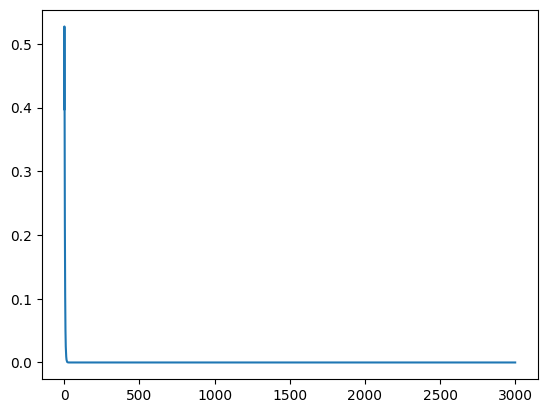

In [107]:
import matplotlib.pyplot as plt
plt.plot(cost)
plt.show()

In [108]:
#prediction
def predict(test_x,test_y,weight):
    predict = forward_propogation(test_x,weight)['A'+str(hidden_layer+1)]
    predict_y = (predict > 0.5)
    accuracy = ((np.dot(test_y,predict_y.T) + np.dot(1-test_y,1-predict_y.T))/test_y.size)*100
    return predict_y, accuracy
    

In [110]:
train_x,train_y,test_x,test_y = training_test_set(output_column_name, test_split_ratio)
predict_y, accuracy = predict(test_x,test_y,weight)
print(predict_y)
print(accuracy)


[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True 

In [ ]:
forward_computation = forward_propogation()
dAdZ = tanh_derivative(forward_computation['A4'])
print(forward_computation['A4'].shape)
print(dAdZ.shape)


In [ ]:
forward_computation.keys()

In [ ]:
backward_computation = backward_propogation()

In [ ]:
backward_computation.keys()

In [ ]:
backward_computation['dW1'].shape

In [ ]:
601%300